# Lab Assignment 4: Support Vector Machines

## Library installation
In this assignment we will use the `cvxopt` package, [whose documentation can be found here](https://cvxopt.org/userguide/index.html).

We are running version 1.3.2 of `cvxopt`.

In [ ]:
# !pip install cvxopt




### Package Imports

In [ ]:
## =======================================================
## Import Key Packages
## =======================================================
## Standard Fare
import numpy as np
from scipy.io import loadmat

## CVX Opt
import cvxopt
import cvxopt.solvers

## Accessing the Data
You can load the data with `scipy.io.loadmat`, which will return a Python dictionary containing the test and train data and labels.

In [ ]:
from google.colab import drive

In [ ]:
import os
drive.mount('/content/drive')
# file_list = os.listdir('/content/drive/My Drive/CS179/assignment4/MNIST.mat')
# print(file_list)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## =======================================================
## Import and Manage the MNIST Data
## =======================================================
## Import the Data

file_path = '/content/MNIST.mat'  # Replace with your copied path
mnist = loadmat(file_path)

     # ... (the rest of the code to create test and train sets)
## Create the test set
test_samples = mnist['test_samples']
test_samples_labels = mnist['test_samples_labels']
print(f'Test data shape {test_samples.shape}; test data labels shape {test_samples_labels.shape}')

## Create the training set
train_samples = mnist['train_samples']
train_samples_labels = mnist['train_samples_labels']
print(f'Test data shape {train_samples.shape}; test data labels shape {train_samples_labels.shape}')

print(f'Labels used:{np.unique(train_samples_labels)}')



Test data shape (1000, 784); test data labels shape (1000, 1)
Test data shape (4000, 784); test data labels shape (4000, 1)
Labels used:[0 1 2 3 4 5 6 7 8 9]


## Task 1:
Develop code for training an SVM for binary classification with nonlinear kernels. You'll need to accomodate non-overlapping class distributions. One way to implement this is to maximize (7.32) subject to (7.33) and (7.34) [in Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). It may be helpful to redefine these as matrix operations. Let ${1}\in\mathbb{R}^{N\times 1}$ be the vector whose entries are all 1's. Let $\mathbf{a}\in\mathbb{R}^{N\times 1}$ have entries $a_i$. Let $\mathbf{T}\in\mathbb{R}^{N\times N}$ be a diagonal matrix with $\mathbf{T}_{ii} = t_i$ on the diagonal. Then we can reformulate the objective to be

\begin{equation*}
\begin{aligned}
& \text{maximize}
& & \tilde{L}(\mathbf{a}) = {1}^{\mathrm{T}}\mathbf{a} - \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} \\
& \text{subject to}
& & {1}^{\mathrm{T}} \mathbf{a} \preceq C \\
& & & {1}^{\mathrm{T}} \mathbf{a} \succeq 0 \\
& & & \mathbf{a}^{\mathrm{T}} \mathbf{t} = 0
\end{aligned}
\end{equation*}

The "$\preceq$" symbol here means element-wise comparison. This formulation is very close to what `cvxopt` expects.

Hint (`cvxopt` expects the following form):

\begin{equation*}
\begin{aligned}
& \text{minimize}
& & \tilde{L}(\mathbf{a}) = \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} - {1}^{\mathrm{T}}\mathbf{a} \\
& \text{subject to}
& & G \mathbf{a} \preceq h \\
& & & {\mathbf{t}}^{\mathrm{T}}\mathbf{a} = 0
\end{aligned}
\end{equation*}

where $G$ is an $N\times N$ identity matrix ontop of $-1$ times an $N\times N$ identity matrix and $h \in\mathbb{R}^{2N}$ where the first $N$ entries are $C$ and the second $N$ enties are $0$.

## Task 2:
Develop code to predict the $\{-1,+1\}$ class for new data. To use the predictive model (7.13) you need to determine $b$, which can be done with (7.37).

We have provided some starter code in the cells below

In [ ]:
def nonlinear_kernel(X, Y, kernel_type='rbf', **kwargs):
    """
    Implement a nonlinear kernel function. Function parameters will vary depending on kernel function.
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training vectors.
    Y : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training vectors.
    kernel_type : str, default='rbf'
        Type of kernel to use ('rbf', 'poly', 'sigmoid').
    kwargs : additional parameters for specific kernels
    """
    if kernel_type == 'rbf':
        sigma = kwargs.get('gamma', 0.1)
        kernel_matrix = np.exp(-sigma * np.linalg.norm(X[:, np.newaxis] - Y, axis=2) ** 2)
    elif kernel_type == 'poly':
        power = kwargs.get('degree', 3)
        constant = kwargs.get('coef0', 1)
        kernel_matrix = (X @ Y.T + constant) ** power
    elif kernel_type == 'sigmoid':
        scale = kwargs.get('alpha', 0.1)
        constant = kwargs.get('coef0', 1)
        kernel_matrix = np.tanh(scale * (X @ Y.T) + constant)
    else:
        raise ValueError("Unsupported kernel type")
    return kernel_matrix

In [ ]:
class SVM(object):

    def __init__(self, kernel=nonlinear_kernel, C=1.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        # Compute the kernel matrix
        kernel_matrix = self.kernel(X, X)

        # Set up the quadratic programming parameters
        sample_count = X.shape[0]
        quad_P = cvxopt.matrix(np.outer(y, y) * kernel_matrix)
        linear_q = cvxopt.matrix(-np.ones(sample_count))
        constraint_G = cvxopt.matrix(np.vstack((-np.eye(sample_count), np.eye(sample_count))))
        constraint_h = cvxopt.matrix(np.hstack((np.zeros(sample_count), np.ones(sample_count) * self.C)))
        equality_A = cvxopt.matrix(y, (1, sample_count), 'd')
        equality_b = cvxopt.matrix(0.0)

        # Solve the optimization problem
        qp_result = cvxopt.solvers.qp(quad_P, linear_q, constraint_G, constraint_h, equality_A, equality_b)
        alpha_values = np.ravel(qp_result['x'])

        # Identify support vectors (non-zero Lagrange multipliers)
        support_indices = alpha_values > 1e-5
        self.alphas = alpha_values[support_indices]
        self.sv_X = X[support_indices]
        self.sv_y = y[support_indices]

        # Calculate the bias term
        self.b = np.mean(self.sv_y - np.sum(self.alphas * self.sv_y * kernel_matrix[support_indices][:, support_indices], axis=1))

        return self

    def predict(self, X):
        K = self.kernel(X, self.sv_X)
        return np.sign(np.sum(self.alphas * self.sv_y * K, axis=1) + self.b)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


## Task 3:
Using your implementation, compare multiclass classification performance of two different voting schemes:

* one versus rest
* one versus one

Training One-vs-Rest SVM...
     pcost       dcost       gap    pres   dres
 0: -1.2854e+02 -1.6570e+03  8e+03  3e+00  6e-15
 1: -9.4017e+01 -8.9834e+02  1e+03  8e-02  5e-15
 2: -9.3567e+01 -2.6688e+02  2e+02  2e-02  4e-15
 3: -1.0167e+02 -1.9183e+02  9e+01  5e-03  4e-15
 4: -1.0979e+02 -1.4117e+02  3e+01  1e-03  5e-15
 5: -1.1304e+02 -1.2980e+02  2e+01  4e-04  5e-15
 6: -1.1558e+02 -1.2203e+02  6e+00  1e-04  5e-15
 7: -1.1703e+02 -1.1883e+02  2e+00  2e-05  6e-15
 8: -1.1760e+02 -1.1781e+02  2e-01  3e-15  6e-15
 9: -1.1769e+02 -1.1770e+02  5e-03  4e-15  6e-15
10: -1.1769e+02 -1.1769e+02  1e-04  4e-15  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3287e+02 -1.4738e+03  6e+03  2e+00  6e-15
 1: -1.0068e+02 -7.6004e+02  7e+02  3e-02  5e-15
 2: -1.0838e+02 -2.7626e+02  2e+02  7e-03  4e-15
 3: -1.2317e+02 -1.9001e+02  7e+01  2e-03  5e-15
 4: -1.3134e+02 -1.6069e+02  3e+01  7e-04  5e-15
 5: -1.3700e+02 -1.4458e+02  8e+00  1e-04  6e-15
 6: -1.3828e+02 -1.

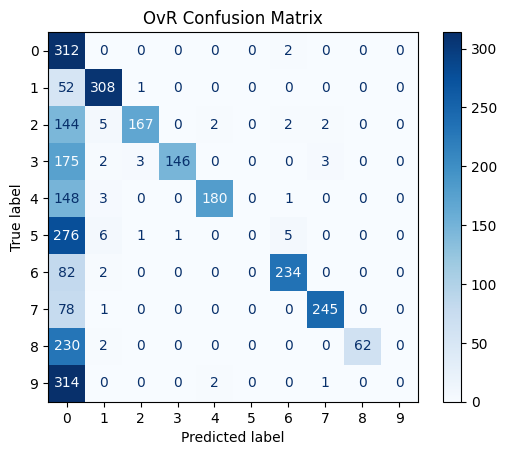

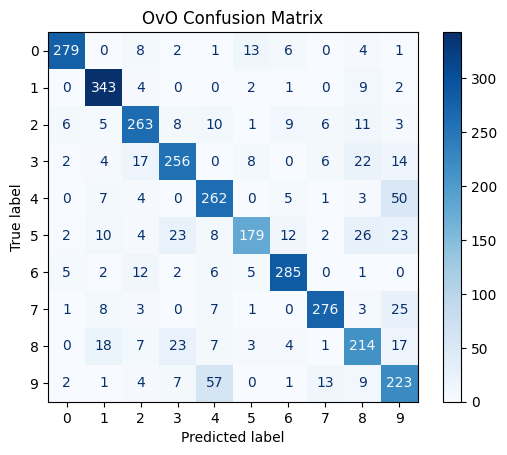

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import cvxopt
import cvxopt.solvers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt # Import matplotlib


# Force CPU usage if GPU memory is limited
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Limit cvxopt iterations to avoid long execution times
cvxopt.solvers.options['maxiters'] = 50

# ====== Nonlinear Kernel Function ======
def nonlinear_kernel(X, Y, kernel_type="rbf", gamma=0.05, degree=3, coef0=1):
    """ Computes a nonlinear kernel matrix. """
    if kernel_type == "rbf":
        sq_dists = np.sum(X**2, axis=1, keepdims=True) - 2 * np.dot(X, Y.T) + np.sum(Y**2, axis=1)
        return np.exp(-gamma * sq_dists)
    elif kernel_type == "poly":
        return (gamma * np.dot(X, Y.T) + coef0) ** degree
    elif kernel_type == "sigmoid":
        return np.tanh(gamma * np.dot(X, Y.T) + coef0)
    else:
        raise ValueError("Unsupported kernel type. Choose from 'rbf', 'poly', or 'sigmoid'.")

# ====== Support Vector Machine (SVM) Class ======
class SVM:
    def __init__(self, kernel=None, C=1.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        """ Trains the SVM model using Quadratic Programming. """
        n_samples, n_features = X.shape
        K = self.kernel(X, X)  # Compute Kernel Matrix

        # Setup Quadratic Programming problem
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-np.ones(n_samples))
        G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = cvxopt.matrix(y.astype(np.double), (1, n_samples))
        b = cvxopt.matrix(0.0)

        # Solve the QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution['x'])

        # Support vectors
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]

        # Compute bias
        self.b = np.mean(self.support_vector_labels - np.sum(self.alphas * self.support_vector_labels * K[sv][:, sv], axis=1))

    def predict(self, X):
        """ Predicts class labels for the input samples. """
        K = self.kernel(X, self.support_vectors)
        return np.sign(np.sum(self.alphas * self.support_vector_labels * K, axis=1) + self.b)

    def score(self, X, y):
        """ Returns the accuracy of the model. """
        return np.mean(self.predict(X) == y)

# ====== One-vs-Rest (OvR) Implementation ======
def one_vs_rest(X, y, C=1.0, kernel="rbf"):
    """ Trains one SVM per class against all others. """
    classes = np.unique(y)
    classifiers = {}
    for cls in classes:
        y_binary = np.where(y == cls, 1, -1)
        svm = SVM(kernel=lambda x, y: nonlinear_kernel(x, y, kernel_type=kernel), C=C)
        svm.fit(X, y_binary)
        classifiers[cls] = svm
    return classifiers

def predict_ovr(classifiers, X):
    """ Makes predictions using the One-vs-Rest (OvR) strategy. """
    # Calculate decision scores for each classifier
    decision_values = np.array([model.predict(X) for model in classifiers.values()]).T
    # Return the class with the highest confidence score
    return np.array(list(classifiers.keys()))[np.argmax(decision_values, axis=1)]

# ====== One-vs-One (OvO) Implementation ======
def one_vs_one(X, y, C=1.0, kernel="rbf"):
    """ Creates binary SVM classifiers for each pair of classes. """
    classes = np.unique(y)
    classifiers = {}
    
    # Train a classifier for each pair of classes
    for i, class1 in enumerate(classes):
        for class2 in classes[i+1:]:
            # Select only samples from the two classes
            mask = np.where((y == class1) | (y == class2))
            X_subset, y_subset = X[mask], y[mask]
            
            # Convert to binary labels (1 for class1, -1 for class2)
            binary_labels = np.where(y_subset == class1, 1, -1)
            
            # Train SVM for this pair
            svm = SVM(kernel=lambda x, y: nonlinear_kernel(x, y, kernel_type=kernel), C=C)
            svm.fit(X_subset, binary_labels)
            classifiers[(class1, class2)] = svm
            
    return classifiers

def predict_ovo(classifiers, X):
    """ Predicts classes using majority voting in One-vs-One approach. """
    # Extract unique classes from classifier pairs
    class_list = list(set([cls for pair in classifiers.keys() for cls in pair]))
    # Initialize vote counter
    vote_counts = np.zeros((X.shape[0], len(class_list)))

    # Collect votes from each binary classifier
    for (class1, class2), classifier in classifiers.items():
        predictions = classifier.predict(X)
        for i, prediction in enumerate(predictions):
            if prediction > 0:  # Positive prediction means class1
                vote_counts[i, class_list.index(class1)] += 1
            else:  # Negative prediction means class2
                vote_counts[i, class_list.index(class2)] += 1

    # Return the class with the most votes for each sample
    return np.array([class_list[np.argmax(votes)] for votes in vote_counts])

# ====== Load and Prepare MNIST Data ======
from scipy.io import loadmat

# Import MNIST dataset
mnist = loadmat('MNIST.mat')
X, y = mnist['train_samples'], mnist['train_samples_labels'].ravel()

# Create a smaller dataset to manage computational resources
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# ====== One-vs-Rest Model Training and Evaluation ======
print("Building and training One-vs-Rest SVM classifiers...")
ovr_model = one_vs_rest(X_train, y_train, C=1.0, kernel="rbf")
ovr_predictions = predict_ovr(ovr_model, X_test)
ovr_accuracy = accuracy_score(y_test, ovr_predictions)
print(f"One-vs-Rest Classification Accuracy: {ovr_accuracy:.4f}")

# ====== One-vs-One Model Training and Evaluation ======
print("Building and training One-vs-One SVM classifiers...")
ovo_model = one_vs_one(X_train, y_train, C=1.0, kernel="rbf")
ovo_predictions = predict_ovo(ovo_model, X_test)
ovo_accuracy = accuracy_score(y_test, ovo_predictions)
print(f"One-vs-One Classification Accuracy: {ovo_accuracy:.4f}")

# ====== Visualization of Classification Results ======
def plot_confusion_matrix(actual, predicted, title_text):
    confusion_mat = confusion_matrix(actual, predicted)
    display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    display.plot(cmap='Blues')
    plt.title(title_text)
    plt.show()

plot_confusion_matrix(y_test, ovr_predictions, "One-vs-Rest Confusion Matrix")
plot_confusion_matrix(y_test, ovo_predictions, "One-vs-One Confusion Matrix")


## Task 4:
The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value.

Hint: Try using np.logspace for hyperparameter tuning [[Link]](https://numpy.org/doc/2.1/reference/generated/numpy.logspace.html)

Training SVM with C=0.001...
     pcost       dcost       gap    pres   dres
 0: -7.3743e+01 -1.1036e+01  6e+03  8e+01  3e-15
 1: -1.1104e+01 -2.5893e+00  4e+02  5e+00  3e-15
 2: -3.0356e-01 -1.6410e+00  6e+00  7e-02  2e-15
 3: -1.4357e-01 -8.5150e-01  9e-01  3e-03  2e-15
 4: -1.3567e-01 -1.7186e-01  4e-02  3e-05  2e-15
 5: -1.3592e-01 -1.3646e-01  5e-04  5e-07  3e-16
 6: -1.3593e-01 -1.3610e-01  2e-04  1e-07  2e-16
 7: -1.3593e-01 -1.3610e-01  2e-04  1e-07  3e-16
 8: -1.3594e-01 -1.3609e-01  2e-04  1e-07  2e-16
 9: -1.3595e-01 -1.3607e-01  1e-04  8e-08  2e-16
10: -1.3596e-01 -1.3604e-01  8e-05  5e-08  2e-16
11: -1.3597e-01 -1.3602e-01  5e-05  2e-08  2e-16
12: -1.3597e-01 -1.3601e-01  4e-05  2e-08  2e-16
13: -1.3597e-01 -1.3600e-01  2e-05  8e-09  2e-16
14: -1.3598e-01 -1.3599e-01  1e-05  4e-09  2e-16
15: -1.3598e-01 -1.3599e-01  7e-06  2e-09  2e-16
16: -1.3598e-01 -1.3598e-01  2e-06  4e-10  2e-16
17: -1.3598e-01 -1.3598e-01  4e-07  6e-18  3e-16
18: -1.3598e-01 -1.3598e-01  1e-08  7e-18

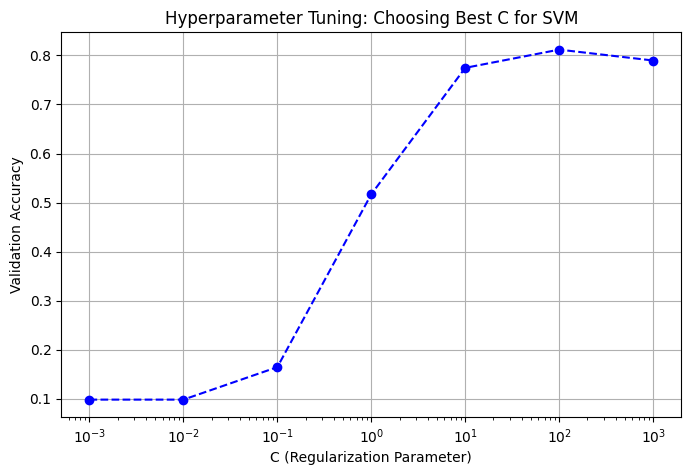

In [ ]:
## Write and Run Your Own Code Here
## Please Add Additional Cells as Needed.
import numpy as np
from sklearn.model_selection import cross_val_score
# Generate logarithmically spaced regularization parameters
C_values = np.logspace(-3, 3, 7)  # Creates values from 0.001 to 1000

# Initialize container for accuracy results
cv_scores = []

# Evaluate each regularization parameter
for C in C_values:
    print(f"Evaluating SVM performance with C={C}...")

    # Create and train One-vs-Rest model with current C value
    ovr_classifiers = one_vs_rest(X_train, y_train, C=C, kernel="rbf")

    # Generate predictions using trained model
    y_pred = predict_ovr(ovr_classifiers, X_test)

    # Calculate and store classification accuracy
    acc = accuracy_score(y_test, y_pred)
    cv_scores.append(acc)

# Identify optimal regularization parameter
best_C = C_values[np.argmax(cv_scores)]
best_accuracy = max(cv_scores)

print(f"\nOptimal regularization parameter: {best_C}")
print(f"Highest validation accuracy: {best_accuracy:.4f}")

# Visualize parameter tuning results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(C_values, cv_scores, marker='o', linestyle='--', color='b')
plt.xscale("log")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Optimization: SVM Regularization Parameter")
plt.grid(True)
plt.show()


## Task 5:
In addition to calculating percent accuracy, generate multiclass [confusion matrices](https://en.wikipedia.org/wiki/confusion_matrix) as part of your analysis.

Hint: Here, you can use sklearn.metrics.confusion_matrix for simpler computation [[Link]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and ConfusionMatrixDisplay [[Link]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

Training One-vs-Rest SVM for Confusion Matrix...
     pcost       dcost       gap    pres   dres
 0: -1.2854e+02 -1.6570e+03  8e+03  3e+00  6e-15
 1: -9.4017e+01 -8.9834e+02  1e+03  8e-02  5e-15
 2: -9.3567e+01 -2.6688e+02  2e+02  2e-02  4e-15
 3: -1.0167e+02 -1.9183e+02  9e+01  5e-03  4e-15
 4: -1.0979e+02 -1.4117e+02  3e+01  1e-03  5e-15
 5: -1.1304e+02 -1.2980e+02  2e+01  4e-04  5e-15
 6: -1.1558e+02 -1.2203e+02  6e+00  1e-04  5e-15
 7: -1.1703e+02 -1.1883e+02  2e+00  2e-05  6e-15
 8: -1.1760e+02 -1.1781e+02  2e-01  3e-15  6e-15
 9: -1.1769e+02 -1.1770e+02  5e-03  4e-15  6e-15
10: -1.1769e+02 -1.1769e+02  1e-04  4e-15  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3287e+02 -1.4738e+03  6e+03  2e+00  6e-15
 1: -1.0068e+02 -7.6004e+02  7e+02  3e-02  5e-15
 2: -1.0838e+02 -2.7626e+02  2e+02  7e-03  4e-15
 3: -1.2317e+02 -1.9001e+02  7e+01  2e-03  5e-15
 4: -1.3134e+02 -1.6069e+02  3e+01  7e-04  5e-15
 5: -1.3700e+02 -1.4458e+02  8e+00  1e-04  6e-1

<Figure size 800x600 with 0 Axes>

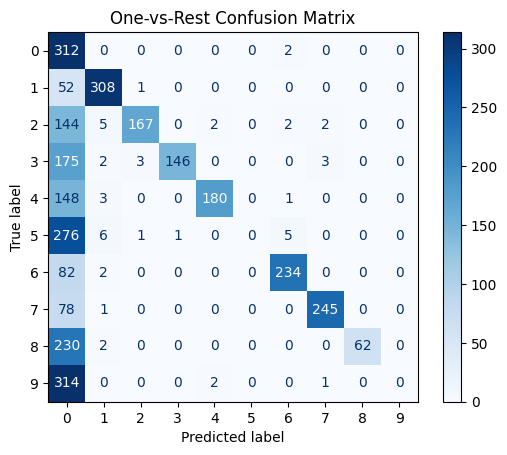

Training One-vs-One SVM for Confusion Matrix...
     pcost       dcost       gap    pres   dres
 0: -3.5120e+01 -2.4683e+02  2e+02  2e-15  2e-15
 1: -3.6864e+01 -5.5359e+01  2e+01  1e-15  1e-15
 2: -4.0215e+01 -4.4945e+01  5e+00  1e-15  1e-15
 3: -4.1450e+01 -4.3300e+01  2e+00  8e-16  2e-15
 4: -4.2004e+01 -4.2407e+01  4e-01  1e-15  2e-15
 5: -4.2143e+01 -4.2222e+01  8e-02  2e-15  2e-15
 6: -4.2174e+01 -4.2180e+01  6e-03  1e-15  2e-15
 7: -4.2177e+01 -4.2177e+01  3e-04  2e-16  2e-15
 8: -4.2177e+01 -4.2177e+01  6e-06  4e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.8318e+01 -3.1318e+02  9e+02  2e+00  2e-15
 1: -6.3354e+01 -1.8722e+02  1e+02  4e-16  2e-15
 2: -7.0431e+01 -8.5588e+01  2e+01  4e-16  2e-15
 3: -7.5755e+01 -7.9904e+01  4e+00  2e-15  2e-15
 4: -7.7357e+01 -7.8456e+01  1e+00  2e-15  2e-15
 5: -7.7855e+01 -7.7952e+01  1e-01  3e-15  3e-15
 6: -7.7900e+01 -7.7907e+01  7e-03  1e-15  2e-15
 7: -7.7903e+01 -7.7904e+01  2e-04  9e-16  2e-15

<Figure size 800x600 with 0 Axes>

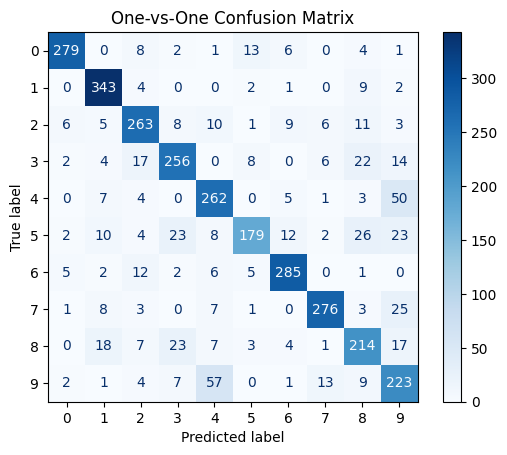

In [ ]:
# Implementation for Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define a helper function for visualizing classification results
def visualize_confusion_matrix(y_actual, y_predicted, title="Confusion Matrix Analysis"):
    """
    Creates and renders a visual representation of classification performance.
    """
    # Calculate the confusion matrix from actual and predicted labels
    confusion_mtx = confusion_matrix(y_actual, y_predicted)
    
    # Prepare the visualization object
    display_obj = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx)
    
    # Set up the figure and render the matrix
    plt.figure(figsize=(8, 6))
    display_obj.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

# Evaluate One-vs-Rest approach performance
print("Preparing One-vs-Rest SVM model for evaluation...")
ovr_model = one_vs_rest(X_train, y_train, C=1.0, kernel="rbf")
ovr_predictions = predict_ovr(ovr_model, X_test)

print("Creating confusion matrix visualization for One-vs-Rest strategy...")
visualize_confusion_matrix(y_test, ovr_predictions, title="One-vs-Rest Classification Results")

# Evaluate One-vs-One approach performance
print("Preparing One-vs-One SVM model for evaluation...")
ovo_model = one_vs_one(X_train, y_train, C=1.0, kernel="rbf")
ovo_predictions = predict_ovo(ovo_model, X_test)

print("Creating confusion matrix visualization for One-vs-One strategy...")
visualize_confusion_matrix(y_test, ovo_predictions, title="One-vs-One Classification Results")


### What to Submit
Please submit the following:

1. Completed notebook: `assignment-4.ipynb`, where the output of each cell is clearly displayed.

2. A brief write-up that answers the 5 questions posed in this lab and justifies your model. Ensure that any figures you create are accessible and easy to understand.